# Lending Club Risk Adjusted Interest Rate Prediction
__Fan Yuan__  
__04/14/2019__

In [178]:
# import libraries
library(tidyverse)
library(zoo)

In [179]:
# load in raw data
loan <- read.csv('./LoanStats_securev1_2018Q4.csv', header = TRUE, stringsAsFactors = FALSE, skip = 1)
loanBP <- loan

In [180]:
# explore the data
head(loan)

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,⋯,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
145217616,NA,10000,10000,10000,36 months,10.33%,324.23,B,B1,⋯,NA,NA,DirectPay,N,,,,NA,NA,NA
145640422,NA,2500,2500,2500,36 months,13.56%,84.92,C,C1,⋯,NA,NA,Cash,N,,,,NA,NA,NA
145630143,NA,12000,12000,12000,60 months,13.56%,276.49,C,C1,⋯,NA,NA,Cash,N,,,,NA,NA,NA
145127870,NA,15000,15000,14975,60 months,14.47%,352.69,C,C2,⋯,NA,NA,Cash,N,,,,NA,NA,NA
145558466,NA,16000,16000,16000,60 months,17.97%,406.04,D,D1,⋯,NA,NA,Cash,N,,,,NA,NA,NA
145509846,NA,9600,9600,9600,36 months,23.40%,373.62,E,E1,⋯,NA,NA,Cash,N,,,,NA,NA,NA


In [181]:
# get an idea of data structure
str(loan)

'data.frame':	128414 obs. of  151 variables:
 $ id                                        : chr  "145217616" "145640422" "145630143" "145127870" ...
 $ member_id                                 : logi  NA NA NA NA NA NA ...
 $ loan_amnt                                 : int  10000 2500 12000 15000 16000 9600 4000 3500 9600 8000 ...
 $ funded_amnt                               : int  10000 2500 12000 15000 16000 9600 4000 3500 9600 8000 ...
 $ funded_amnt_inv                           : num  10000 2500 12000 14975 16000 ...
 $ term                                      : chr  " 36 months" " 36 months" " 60 months" " 60 months" ...
 $ int_rate                                  : chr  " 10.33%" " 13.56%" " 13.56%" " 14.47%" ...
 $ installment                               : num  324.2 84.9 276.5 352.7 406 ...
 $ grade                                     : chr  "B" "C" "C" "C" ...
 $ sub_grade                                 : chr  "B1" "C1" "C1" "C2" ...
 $ emp_title                        

In [182]:
head(loan[, c('issue_d', 'last_pymnt_d', 'next_pymnt_d')])

issue_d,last_pymnt_d,next_pymnt_d
Dec-2018,Feb-2019,Apr-2019
Dec-2018,Feb-2019,Apr-2019
Dec-2018,Feb-2019,Apr-2019
Dec-2018,Feb-2019,Apr-2019
Dec-2018,Feb-2019,Apr-2019
Dec-2018,Feb-2019,Apr-2019


In [183]:
# There are "" in the next_pymnt_d, why? Actually also for last_pymnt_d.
dim(subset(loan, next_pymnt_d == ""))

[1] 5032  151

In [184]:
with(subset(loan, next_pymnt_d == ""), table(loan_status)) # either charged off or fully paid

with(subset(loan, next_pymnt_d == "" & last_pymnt_d == ""), table(loan_status)) # all charged off

loan_status
            Charged Off  Fully Paid 
          2         122        4908 

loan_status
            Charged Off 
          2          61 

In [185]:
with(subset(loan, last_pymnt_d == ""), table(loan_status))
# explore the mean of last month payment of users who didn't pay
summary(subset(loan, last_pymnt_d == "")$last_pymnt_amnt)

loan_status
                          Charged Off Late (31-120 days) 
                 2                 61                102 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0       2 

In [186]:
table(subset(loan, next_pymnt_d == "" & last_pymnt_d == "")$loan_status) # all charged off
table(subset(loan, next_pymnt_d == "" & last_pymnt_d != "")$loan_status) # charged off or fully paid
table(subset(loan, next_pymnt_d != "" & last_pymnt_d == "")$loan_status) # no loan satisfy this.
table(subset(loan, next_pymnt_d != "" & last_pymnt_d != "")$loan_status)


            Charged Off 
          2          61 


Charged Off  Fully Paid 
         61        4908 


Late (31-120 days) 
               102 


           Current    In Grace Period  Late (16-30 days) Late (31-120 days) 
            121676                513                344                747 

In [187]:
# take a look at how loan_status distribute
table(loan$loan_status)

# clean up the blank loan_status
loan <- subset(loan, loan_status != "")


                          Charged Off            Current         Fully Paid 
                 2                122             121676               4908 
   In Grace Period  Late (16-30 days) Late (31-120 days) 
               513                344                849 

### Candidate analysis question
### 1) At which phase, payment is likely to be missed
### 2) Upon loan initial application, predict whether it will be charge off or default
### 3) Throughout loan payment period, predict whether next payment will be missing, or in next quater, whether loan status will be changed

In [188]:
# clean up the date format and manipulate some more time features
loan$issue_d_1 <- as.Date(as.yearmon(loan$issue_d, "%b-%Y"))
loan$issue_year <- as.character(format(loan$issue_d_1, "%Y"))
loan$issue_month <- as.character(format(loan$issue_d_1, "%m"))

In [189]:
# clean up the date format and manipulate some more time features
loan$last_pymnt_d_1 <- as.Date(as.yearmon(loan$last_pymnt_d, "%b-%Y"))
loan$last_pymnt_year <- as.character(format(loan$last_pymnt_d_1, "%Y"))
loan$last_pymnt_mon <- as.character(format(format(loan$last_pymnt_d_1,"%m")))

In [190]:
# generate a new feature -- time between last payment and issue date
loan$last_pymnt_from_issue <- with(loan, last_pymnt_d_1 - issue_d_1)
table(loan$last_pymnt_from_issue)
loan$last_pymnt_from_issue_cat <- with(loan, as.character(cut(as.numeric(last_pymnt_from_issue),
                                                            c(-1, 0, 92, 184, 275, 366, 457, 549, 639, 730))))
table(loan$last_pymnt_from_issue_cat)


    0    30    31    61    62    90    92   120   123   151 
  650   457  1011   899  3166 36167  3375 37927  4103 40494 


  (-1,0]   (0,92] (92,184] 
     650    45075    82524 

In [191]:
# dig deep on NA value
table(subset(loan, is.na(last_pymnt_from_issue_cat))$last_pymnt_d)
# there are about 163 have no payment at all, need to clean up the code
loan$last_pymnt_from_issue[which(is.na(loan$last_pymnt_from_issue))] <- 2000
loan$last_pymnt_from_issue_cat[which(is.na(loan$last_pymnt_from_issue_cat))] <- 'no pymnt'


    
163 

In [192]:
by.pymnt.gap <- with(loan, table(last_pymnt_from_issue_cat, loan_status))
by.pymnt.gap
by.pymnt.gap <- by.pymnt.gap[c("(-1,0]", "(0,92]", "(92,184]", "no pymnt"),
                             c("Charged Off",  "Late (31-120 days)",
                               "Late (16-30 days)", "In Grace Period", "Current",
                               "Fully Paid")]

                         loan_status
last_pymnt_from_issue_cat Charged Off Current Fully Paid In Grace Period
                 (-1,0]             1       0        649               0
                 (0,92]            58   40664       3277             218
                 (92,184]           2   81012        982             295
                 no pymnt          61       0          0               0
                         loan_status
last_pymnt_from_issue_cat Late (16-30 days) Late (31-120 days)
                 (-1,0]                   0                  0
                 (0,92]                 209                649
                 (92,184]               135                 98
                 no pymnt                 0                102

In [193]:
round(100*by.pymnt.gap / apply(by.pymnt.gap, 1, sum), 3)

                         loan_status
last_pymnt_from_issue_cat Charged Off Late (31-120 days) Late (16-30 days)
                 (-1,0]         0.154              0.000             0.000
                 (0,92]         0.129              1.440             0.464
                 (92,184]       0.002              0.119             0.164
                 no pymnt      37.423             62.577             0.000
                         loan_status
last_pymnt_from_issue_cat In Grace Period Current Fully Paid
                 (-1,0]             0.000   0.000     99.846
                 (0,92]             0.484  90.214      7.270
                 (92,184]           0.357  98.168      1.190
                 no pymnt           0.000   0.000      0.000

In [194]:
loan$last_pymnt_from_issue_cat <- relevel(as.factor(loan$last_pymnt_from_issue_cat), ref = 'no pymnt')
loan$loan_status_binary <- as.factor(ifelse(loan$loan_status %in% c('Fully Paid', 'Current'), 'okay', 'past_due'))
mod1 <- glm(loan_status_binary ~ last_pymnt_from_issue_cat, loan, family = 'binomial')
summary(mod1)
mod2 <- glm(loan_status_binary ~ last_pymnt_from_issue, loan, family = 'binomial')
# consider use piecewise linear regression
summary(mod2)



Call:
glm(formula = loan_status_binary ~ last_pymnt_from_issue_cat, 
    family = "binomial", data = loan)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2257  -0.2257  -0.1135  -0.1135   3.5992  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)
(Intercept)                          15.57     114.00   0.137    0.891
last_pymnt_from_issue_cat(-1,0]     -22.04     114.00  -0.193    0.847
last_pymnt_from_issue_cat(0,92]     -19.22     114.00  -0.169    0.866
last_pymnt_from_issue_cat(92,184]   -20.61     114.00  -0.181    0.857

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 19175  on 128411  degrees of freedom
Residual deviance: 17014  on 128408  degrees of freedom
AIC: 17022

Number of Fisher Scoring iterations: 14



Call:
glm(formula = loan_status_binary ~ last_pymnt_from_issue, family = "binomial", 
    data = loan)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.1715  -0.1715  -0.1635  -0.1561   3.0630  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.6816910  0.0290346 -161.25   <2e-16 ***
last_pymnt_from_issue  0.0031071  0.0001089   28.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 19175  on 128411  degrees of freedom
Residual deviance: 18164  on 128410  degrees of freedom
AIC: 18168

Number of Fisher Scoring iterations: 7


In [195]:
with(loan, table(loan_status_binary, last_pymnt_from_issue_cat))
mod1 <- glm(loan_status_binary ~ last_pymnt_from_issue_cat,
            subset(loan, !last_pymnt_from_issue_cat %in% c('no pymnt', '(-1,0]')), family = 'binomial')
summary(mod1)


                  last_pymnt_from_issue_cat
loan_status_binary no pymnt (-1,0] (0,92] (92,184]
          okay            0    649  43941    81994
          past_due      163      1   1134      530


Call:
glm(formula = loan_status_binary ~ last_pymnt_from_issue_cat, 
    family = "binomial", data = subset(loan, !last_pymnt_from_issue_cat %in% 
        c("no pymnt", "(-1,0]")))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2257  -0.2257  -0.1135  -0.1135   3.1774  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -3.65710    0.03008 -121.59   <2e-16 ***
last_pymnt_from_issue_cat(92,184] -1.38443    0.05294  -26.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17749  on 127598  degrees of freedom
Residual deviance: 16999  on 127597  degrees of freedom
AIC: 17003

Number of Fisher Scoring iterations: 7


In [196]:
# feature processing
date.cols <- colnames(loan)[c(which(grepl('_d$', colnames(loan))),
                              which(grepl('_date$', colnames(loan))))]
# "issue_d"                   "last_pymnt_d"              "next_pymnt_d"             
# "last_credit_pull_d"        "hardship_start_date"       "hardship_end_date"        
# "payment_plan_start_date"   "debt_settlement_flag_date" "settlement_date"          

for (col_i in date.cols) {
  loan[, col_i] <-  as.Date(as.yearmon(loan[, col_i], "%b-%Y"))
}


In [197]:
loan$mths_since_issue <- as.integer((as.Date('2018-11-01') - loan$issue_d) /30)
loan$mths_since_last_credit_pull <- as.integer((as.Date('2018-11-01') - loan$last_credit_pull_d) /30)


In [198]:
TransformToLengthFromIssueDate <- function(loan, col.name, new.col.name, other.level) {
  # get difference in months.
  loan[, new.col.name] <-
    ifelse(is.na(loan[, col.name]), other.level,
           as.character(cut(as.integer((loan[, col.name] - loan$issue_d) /30), 
                            c(min(as.integer((loan[, col.name] - loan$issue_d) /30), na.rm = T) - 1,
                              quantile(as.integer((loan[, col.name] - loan$issue_d) /30), c(0.1), na.rm = T)-0.5,
                              quantile(as.integer((loan[, col.name] - loan$issue_d) /30), c(0.9), na.rm = T)+0.5,
                              max(as.integer((loan[, col.name] - loan$issue_d) /30), na.rm = T)))))
  return(loan)
}
loan <- TransformToLengthFromIssueDate(loan, 'hardship_start_date' ,'hardship_since_issue', 'no_hs')
loan <- TransformToLengthFromIssueDate(loan, 'settlement_date' ,'settlement_since_issue', 'no_settle')
loan <- loan[, -which(colnames(loan) %in% date.cols)]


In [199]:
# remove features with same value
# treat features with too many values
num.value <- sapply(loan, function(x){return(length(unique(x)))})
colnames(loan)[intersect(which(sapply(loan, function(x){return(is.character(x))})),
                         which(num.value >= 50))]

[1] "id"                       "emp_title"               
[3] "url"                      "zip_code"                
[5] "addr_state"               "earliest_cr_line"        
[7] "revol_util"               "sec_app_earliest_cr_line"

In [200]:
# clear the features which are supposed to be numeric but not
head(loan$int_rate)
head(loan$revol_util)
# check which fields have this case
which(sapply(loan[1,], function(x){return(grepl('%', x))}))
loan$int_rate <- as.numeric(sapply(strsplit(loan$int_rate, '%'), '[', 1))
loan$revol_util <- as.numeric(sapply(strsplit(loan$revol_util, '%'), '[', 1))


[1] " 10.33%" " 13.56%" " 13.56%" " 14.47%" " 17.97%" " 23.40%"

[1] "38%"   "10.3%" "55.5%" "37.2%" "24.8%" "37.5%"

int_rate revol_util 
         7         35

In [201]:
head(loan$earliest_cr_line)
loan$earliest_cr_line <- as.Date(as.yearmon(loan$earliest_cr_line, "%b-%Y"))
# convert to month unit
loan$earliest_cr_line <- as.integer((as.Date('2018-11-01') - loan$earliest_cr_line)/30)

[1] "Jan-1996" "Apr-2001" "Aug-2005" "Oct-1999" "Oct-2005" "Sep-2003"

In [202]:
# clean the categorical variables which have too much levels (merge to some extent)
# list out candidate variables (with levels greater than 50)
feat.w.many.levels <- colnames(loan)[intersect(which(sapply(loan, function(x){return (is.character(x))})),
                         which(num.value >= 50))]
loan <- loan[, -which(colnames(loan) %in% c(names(which(num.value == 1)), feat.w.many.levels))]

In [203]:
# update features to reflect loan is jointly applied
colnames(loan)[which(grepl('joint', colnames(loan)))]

loan$dti <- ifelse(!is.na(loan$dti_joint), loan$dti_joint, loan$dti)
loan$annual_inc <- ifelse(!is.na(loan$annual_inc_joint), loan$annual_inc_joint, loan$annual_inc)
loan$verification_status <- ifelse(!is.na(loan$verification_status_joint), loan$verification_status_joint, loan$verification_status)

loan <- loan[, -which(grepl('join', colnames(loan)))]

[1] "annual_inc_joint"          "dti_joint"                
[3] "verification_status_joint" "revol_bal_joint"

In [204]:
# dealing with missing value
num.NA <- sort(sapply(loan, function(x){sum(is.na(x))}), decreasing = TRUE)
sort(num.NA, decreasing = TRUE)[1:10]

deferral_term 
                                    128411 
                           hardship_amount 
                                    128411 
                           hardship_length 
                                    128411 
                              hardship_dpd 
                                    128411 
orig_projected_additional_accrued_interest 
                                    128411 
            hardship_payoff_balance_amount 
                                    128411 
              hardship_last_payment_amount 
                                    128411 
                         settlement_amount 
                                    128407 
                     settlement_percentage 
                                    128407 
                           settlement_term 
                                    128407

In [205]:
# explore more on columns with a majority of NAs
colnames(loan)[which(grepl('hardship', colnames(loan)))]
summary(loan$orig_projected_additional_accrued_interest)
loan$orig_projected_additional_accrued_interest[which(is.na(loan$orig_projected_additional_accrued_interest))] <- 0

[1] "hardship_flag"                  "hardship_type"                 
 [3] "hardship_reason"                "hardship_status"               
 [5] "hardship_amount"                "hardship_length"               
 [7] "hardship_dpd"                   "hardship_loan_status"          
 [9] "hardship_payoff_balance_amount" "hardship_last_payment_amount"  
[11] "hardship_since_issue"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1135    1135    1135    1135    1135    1135  128411 

In [206]:
# check the other columns to nevigate not only NAs but also empty values
# replace the empty field with special place holder

loan$hardship_reason <- ifelse(loan$hardship_reason == '', 'no_hs', loan$hardship_reason)
loan$hardship_status <- ifelse(loan$hardship_status == '', 'no_hs', loan$hardship_status)
loan$hardship_loan_status <- ifelse(loan$hardship_loan_status == '', 'no_hs', loan$hardship_loan_status)
# use 0 for numeric variables
loan$hardship_amount[which(is.na(loan$hardship_amount))] <- 0
loan$hardship_dpd[which(is.na(loan$hardship_dpd))] <- 0
loan$hardship_payoff_balance_amount[which(is.na(loan$hardship_payoff_balance_amount))] <- 0
loan$hardship_last_payment_amount[which(is.na(loan$hardship_last_payment_amount))] <- 0

In [207]:
loan <- loan[, -which(colnames(loan) %in% c('deferral_term',
                                            'hardship_length', 'hardship_type'))]

In [208]:
num.empty <- sapply(loan[, colnames(loan)[which(sapply(loan, function(x){return(is.character(x))}))]],
                   function(x){return(length(which(x == "")))})

In [209]:
num.empty[which(num.empty > 0)]

verification_status   settlement_status 
             113564              128407

In [210]:
loan <- loan[, -which(colnames(loan) %in% c('verification_status','hardship_type','settlement_status'))]

In [211]:
# do the same data cleaning for settlement
loan$settlement_amount[which(is.na(loan$settlement_amount))] <- 0
loan$settlement_percentage[which(is.na(loan$settlement_percentage))] <- 0
loan$settlement_term[which(is.na(loan$settlement_term))] <- 0
loan$settlement_since_issue <- ifelse(is.na(loan$settlement_since_issue), 'no_settlement', loan$settlement_since_issue)

In [212]:
num.NA <- sort(sapply(loan, function(x){sum(is.na(x))}), decreasing = TRUE)
sort(num.NA, decreasing = TRUE)[1:10]

sec_app_mths_since_last_major_derog              mths_since_last_record 
                             123258                              112962 
                 sec_app_revol_util              sec_app_fico_range_low 
                             111888                              111630 
            sec_app_fico_range_high              sec_app_inq_last_6mths 
                             111630                              111630 
                   sec_app_mort_acc                    sec_app_open_acc 
                             111630                              111630 
                sec_app_open_act_il               sec_app_num_rev_accts 
                             111630                              111630

In [213]:
for(col_i in setdiff(names(num.NA)[which(grepl('mths_since', names(num.NA))& num.NA > 0)],
                     c('mths_since_issue', 'mths_since_crline', 'mths_since_last_credit_pull'))) {
  breaks <- quantile(loan[, col_i], c(0.1, 0.5, 0.9), na.rm = T)
  breaks <- c(min(loan[, col_i], na.rm = T) - 1, breaks, max(loan[, col_i], na.rm = T))
  loan[, col_i] <- ifelse(is.na(loan[, col_i]),
                          'not_avail', as.character(cut(loan[, col_i], breaks = breaks)))
}


In [214]:
# check NA again
num.NA <- sort(sapply(loan, function(x){sum(is.na(x))}), decreasing = TRUE)
sort(num.NA, decreasing = TRUE)[which(num.NA > 0)]


sec_app_revol_util             sec_app_fico_range_low 
                            111888                             111630 
           sec_app_fico_range_high             sec_app_inq_last_6mths 
                            111630                             111630 
                  sec_app_mort_acc                   sec_app_open_acc 
                            111630                             111630 
               sec_app_open_act_il              sec_app_num_rev_accts 
                            111630                             111630 
  sec_app_chargeoff_within_12_mths sec_app_collections_12_mths_ex_med 
                            111630                             111630 
                           il_util                 mo_sin_old_il_acct 
                             20274                               4478 
                  num_tl_120dpd_2m                            bc_util 
                              2859                               1754 
                  percent_bc_gt_75                     bc_open_to_buy 
                              1692                               1691 
                    last_pymnt_d_1                    last_pymnt_year 
                               163                                163 
                        revol_util                           all_util 
                               156                                 37 
                       avg_cur_bal        mths_since_last_credit_pull 
                                13                                  1

In [215]:
# check if it's due to no open account? Not for all the cases.
summary(subset(loan, is.na(il_util))$open_act_il)
# is it becuz of the limit is 0? since open_act_il = total_bal_il / total_il_high_credit_limit
# not for all the cases.
with(subset(loan, is.na(il_util)), summary(total_il_high_credit_limit))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3072  0.0000  6.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0   16230   24510 2119000 

In [216]:
head(loan[which(is.na(loan$il_util) & loan$total_il_high_credit_limit != 0),
     c('il_util', 'total_bal_il', 'total_il_high_credit_limit')])

,il_util,total_bal_il,total_il_high_credit_limit
107,NA,22698,37786
109,NA,66857,77865
156,NA,22127,38535
187,NA,38553,38553
193,NA,36008,50000
210,NA,33208,40313


In [217]:
loan$il_util <- ifelse(is.na(loan$il_util) & loan$total_il_high_credit_limit != 0,
                      loan$total_bal_il / loan$total_il_high_credit_limit, loan$il_util)
summary(subset(loan, is.na(il_util) & total_il_high_credit_limit == 0)$open_act_il)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

In [218]:
loan$il_util <-  ifelse(is.na(loan$il_util), 'no_il',
                        as.character(cut(loan$il_util, 
                                         c(min(loan$il_util, na.rm = T) - 0.01,
                                           quantile(loan$il_util, na.rm = T, c(0.1, 0.9)),
                                           max(loan$il_util, na.rm = T)))))
table(loan$il_util)


(-0.01,27]    (27,95]   (95,428]      no_il 
     11620      91292      10309      15191 

In [219]:
loan$mo_sin_old_il_acct <- ifelse(is.na(loan$mo_sin_old_il_acct), 'no_il',
                                  as.character(cut(loan$mo_sin_old_il_acct,
                                                  c(min(loan$mo_sin_old_il_acct, na.rm=T)-0.01,
                                                    quantile(loan$mo_sin_old_il_acct, na.rm=T, c(0.1,0.9)),
                                                    max(loan$mo_sin_old_il_acct, na.rm=T)))))


In [220]:
# check if it's due to no open account
summary(subset(loan, is.na(num_tl_120dpd_2m))$open_acc)
# with(subset(loan, is.na(num_tl_120dpd_2m)), summary(num_tl_30dpd))
loan$num_tl_120dpd_2m <- ifelse(is.na(loan$num_tl_120dpd_2m), 0, loan$num_tl_120dpd_2m)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    8.00   11.00   12.01   15.00   63.00 

In [221]:
num.NA <- sort(sapply(loan, function(x) { sum(is.na(x))}), decreasing = TRUE)
# manipulate the data, use dependent's median to fill in the NA value
for(col_i in names(num.NA)[num.NA > 0]) {
  loan[, col_i] <- ifelse(is.na(loan[, col_i]), median(loan[, col_i], na.rm = T), loan[, col_i])
}


In [166]:
loan$loan_status_binary <- relevel(loan$loan_status_binary, ref = 'okay')
loan <- loan[, -which(colnames(loan) %in% c('grade', 'int_rate', 'sub_grade', 'policy_code'))]

In [227]:
numeric.feats <- colnames(loan)[which(sapply(loan, function(x){return(is.numeric(x))}))]

In [236]:
for(col_i in numeric.feats) {
  formula = paste(col_i, " ~ loan_status_binary")
  p.val <- t.test(as.formula(formula), data = loan)$p.value
  if(!is.na(p.val)){
      if(p.val >= 0.05) {
        loan[, col_i] <- NULL
      }      
  }
}

In [240]:
cat.feats <- colnames(loan)[which(sapply(loan, function(x){return(is.character(x))}))]
cat.feats <- setdiff(cat.feats, 'loan_status_binary')
for(col_i in cat.feats){
    p.val <- chisq.test(x = loan[, col_i], y = loan$loan_status_binary)$p.value
    if(p.val >= 0.05){
        loan[, col_i] <- NULL
    }
}

Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message in chisq.test(x = loan[, col_i], y = loan$loan_status_binary):
“Chi-squared approximation may be incorrect”Warning message 

In [241]:
summary(loan$fico_range_high)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  664.0   684.0   704.0   709.8   729.0   850.0 

In [ ]:
loan$fico_range_high <- NULL
loan$fico_range_low <- NULL
loan$last_fico <- with(loan, (last_fico_range_high + last_fico_range_low)/2)
loan$last_fico_range_high <- loan$last_fico_range_low <- NULL


In [245]:
loan$emp_length <- ifelse(loan$emp_length == 'n/a', loan$emp_length,
                          ifelse(loan$emp_length %in% c('< 1 year', '1 year', '2 years', '3 years'),
                            '< 3 years', ifelse(loan$emp_length %in% c('4 years', '5 years', '6 years', '7 years'),
                                                     '4-7 years', '> 8 years')))
table(loan$emp_length)


< 3 years > 8 years 4-7 years       n/a 
    45998     45703     25007     11704 

In [248]:
# start to build simple model to set up the benchmark model
set.seed(42)
train.ind <- sample(1:dim(loan)[1], 0.7*dim(loan)[1])
train <- loan[train.ind, ]
test <- loan[-train.ind, ]

In [249]:
library(glmnet)
ind <- sparse.model.matrix(~. , train[, which(colnames(train) %in% c('loan_status_binary','loan_status'))])
dep <- train$loan_status_binary
Sys.time()
cv.mod <- cv.glmnet(ind[1:10000, ], dep[1:10000], family = 'binomial')
Sys.time()

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13



[1] "2019-04-20 12:38:15 GMT"

Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”Warning message:
“from glmnet Fortran code (error code -2); Convergence for 2th lambda value not reached after maxit=100000 iterat

[1] "2019-04-20 12:39:10 GMT"

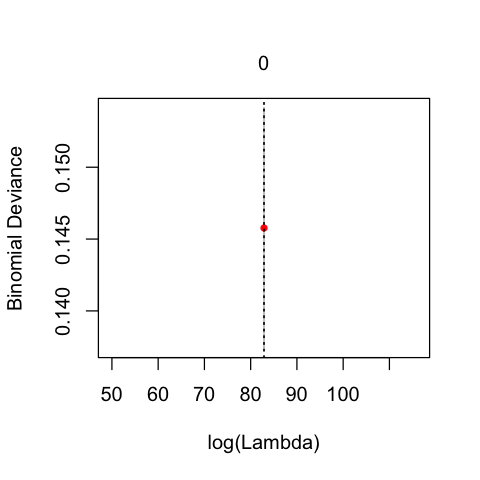

In [252]:
options(repr.plot.width=4, repr.plot.height=4)
plot(cv.mod)

In [253]:
cv.mod$lambda.1se
coef(cv.mod, s = 'lambda.1se')

[1] 9.9e+35

8 x 1 sparse Matrix of class "dgCMatrix"
                                      1
(Intercept)                   -4.269191
(Intercept)                    0.000000
loan_statusCurrent             .       
loan_statusFully Paid          .       
loan_statusIn Grace Period     .       
loan_statusLate (16-30 days)   .       
loan_statusLate (31-120 days)  .       
loan_status_binarypast_due     .       